In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13383180190685023597,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3127299278
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1807605898536184212
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
import segmentation_models as sm
import tensorflow as tf
from pycocotools.coco import COCO
from pathlib import Path
import numpy as np
from typing import Final
import plotly.express as px
from matplotlib import pyplot as plt
import cv2
from albumentations import Compose, VerticalFlip, HorizontalFlip, ShiftScaleRotate, RandomSizedCrop


Segmentation Models: using `tf.keras` framework.


In [9]:
image_size:Final[int] = 256

In [5]:
annotation_file = Path("annotations/instances_default.json")
coco = COCO(str(annotation_file))

for i in coco.getCatIds():
    if coco.loadCats(i)[0]["name"] == "Crack":
        cat_id = coco.loadCats(i)[0]["id"]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [10]:
def create_mask(anns, cat_id):
    mask = np.zeros((image_size, image_size, 1))
    for i in range(len(anns)):
        if anns[i]["category_id"] == cat_id:
            cv2.fillPoly(mask, pts=[np.array(anns[i]["segmentation"], dtype=np.int32).reshape(-1,1, 2)], color=(1))
    return mask

def read_data(idx, cat_id):
    anns = coco.loadAnns(coco.getAnnIds(idx))
    mask = create_mask(anns, cat_id)
    image = np.array(tf.keras.preprocessing.image.load_img(str(Path("./images/annotated") / coco.loadImgs(idx)[0]["file_name"]))) / 255
    return image, mask

In [11]:
def file_load_generator(cat_id, coco):
    transform = Compose([VerticalFlip(), HorizontalFlip(), ShiftScaleRotate()])
    for idx in coco.getImgIds():
        image, mask = read_data(idx, cat_id)
        ret = transform(image=image, mask=mask)
        yield ret["image"], ret["mask"]

ds = tf.data.Dataset.from_generator(lambda: file_load_generator(cat_id, coco), (tf.float32, tf.float32)).batch(5)
for image, label in ds:
    img = image[0]
    lbl = label[0]

In [12]:
image, label = read_data(15, cat_id)

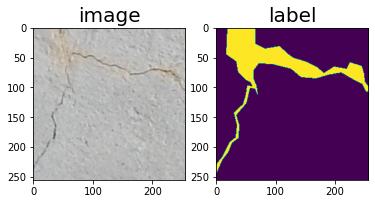

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("image",fontsize=20)
plt.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow(label)

In [14]:
train_ds = tf.data.Dataset.from_generator(lambda: file_load_generator(cat_id, coco), (tf.float32, tf.float32)).batch(5)

non_clack_images = [np.expand_dims(tf.keras.preprocessing.image.load_img(p),axis=0) for p in Path("./images/non_clack").glob("*")]
non_clack_images = np.concatenate(non_clack_images) / 255

recon_train_ds = tf.data.Dataset.from_tensor_slices((non_clack_images[:180,:,:,:], non_clack_images[:180,:,:,:])).batch(8)
recon_test_ds = tf.data.Dataset.from_tensor_slices((non_clack_images[180:,:,:,:], non_clack_images[180:,:,:,:])).batch(8)

In [15]:
try:
    segment_model = tf.keras.models.load_model("segmentation.hf5")
except:
    segment_model = sm.Unet(input_shape=(256, 256, 3))

class ClackAnnotNet(tf.keras.Model):
    def __init__(self):
        super(ClackAnnotNet, self).__init__()
        self.model = sm.Unet(input_shape=(256, 256, 3), classes=3)
        self.model = tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer("final_conv").output)
        self.model = tf.keras.Sequential([self.model, tf.keras.layers.Activation("sigmoid", name="Sigmoid")])
    def call(self, inputs):
        return self.model(inputs)

try:
    model = tf.keras.models.load_model("reconstruct.hf5")
except:
    print("!")
    model = ClackAnnotNet()

## 再構成モデル

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=30)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mae",metrics=["mae"],)
model.fit(recon_train_ds, epochs=1000, validation_data=recon_test_ds, callbacks=[callback])

## セグメンテーションモデル

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

#segment_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy",metrics=["binary_crossentropy"])
segment_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mae",metrics=["mae"])
segment_model.fit(train_ds, epochs=300, callbacks=[callback])

Epoch 1/300
4/4 [==============================] - 19s 505ms/step - loss: 0.4626 - mae: 0.4626
Epoch 2/300
4/4 [==============================] - 2s 461ms/step - loss: 0.4283 - mae: 0.4283
Epoch 3/300
4/4 [==============================] - 2s 455ms/step - loss: 0.4079 - mae: 0.4079
Epoch 4/300
4/4 [==============================] - 2s 428ms/step - loss: 0.3917 - mae: 0.3917
Epoch 5/300
4/4 [==============================] - 2s 442ms/step - loss: 0.3761 - mae: 0.3761
Epoch 6/300
4/4 [==============================] - 2s 459ms/step - loss: 0.3651 - mae: 0.3651
Epoch 7/300
4/4 [==============================] - 2s 435ms/step - loss: 0.3526 - mae: 0.3526
Epoch 8/300
4/4 [==============================] - 2s 436ms/step - loss: 0.3382 - mae: 0.3382
Epoch 9/300
4/4 [==============================] - 2s 474ms/step - loss: 0.3295 - mae: 0.3295
Epoch 10/300
4/4 [==============================] - 2s 455ms/step - loss: 0.3166 - mae: 0.3166
Epoch 11/300
4/4 [==============================] - 2s 456

In [ ]:
model.save("reconstruct.hf5")
segment_model.save("segmentation.hf5")

## 可視化

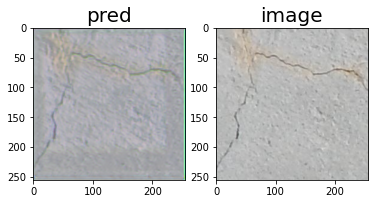

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(model(tf.expand_dims(image, axis=0))[0])
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("image",fontsize=20)
plt.imshow(image)

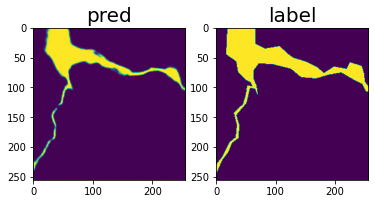

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(segment_model(tf.expand_dims(image, axis=0))[0])
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow(label)

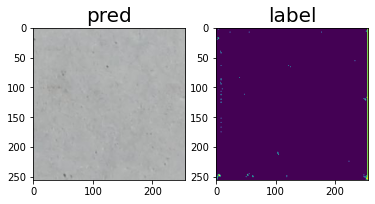

In [18]:
nc_image = non_clack_images[2]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(nc_image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow((tf.keras.losses.MSE(model(np.expand_dims(nc_image, axis=0)), nc_image).numpy()[0] > 0.01) * 255)

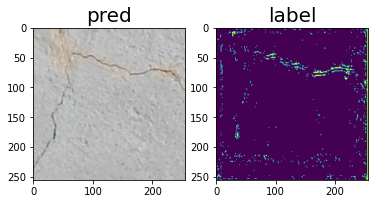

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow((tf.keras.losses.MSE(model(np.expand_dims(image, axis=0)), image).numpy()[0] > 0.01) * 255)

## 特徴空間分離

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

feature_model = model.get_layer("sequential_1").get_layer("model_12")
feature_model = tf.keras.Model(inputs=feature_model.input, outputs=feature_model.get_layer("block3_pool").output)

# 特徴量抽出モデル
test = train_ds.unbatch()
#a_x = [tf.keras.losses.MAE(model(np.expand_dims(x, axis=0)), x).numpy().flatten() for x, y in test]
a_x = [feature_model(np.expand_dims(x, axis=0)).numpy().flatten() for x, y in test]
a_y = [0] * len(a_x)
a_c = ["ひびあり"] * len(a_x)

a_n = []
for idx in coco.getImgIds():
    anns = coco.loadAnns(coco.getAnnIds(idx))
    a_n.append(coco.loadImgs(idx)[0]["file_name"])


unb_test = recon_train_ds.unbatch()
#b_x = [tf.keras.losses.MAE(model(np.expand_dims(x, axis=0)), x).numpy().flatten() for x, y in unb_test]
b_x = [feature_model(np.expand_dims(x, axis=0)).numpy().flatten() for x, y in unb_test]
b_y = [1] * len(b_x)
b_c = ["ひびなし"] * len(b_x)
b_n = [str(p.name) for p in Path("./images/non_clack").glob("*")]

a_x.extend(b_x)
a_y.extend(b_y)
a_c.extend(b_c)
a_n.extend(b_n[:180])

feature  = TSNE(n_components=2).fit_transform(np.array(a_x))
plot_df = pd.DataFrame({"f1":feature[:, 0],"f2":feature[:, 1],"color":a_c, "name":a_n})

#plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, color=a_c)
fig = px.scatter(plot_df, x="f1", y="f2", color="color", hover_name="name" )
fig.update_layout(width=800, height=600)

c:\Users\hirose.tomoki\Desktop\concrete_annotation\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\hirose.tomoki\Desktop\concrete_annotation\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

